In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

import pandas as pd
import numpy as np
devs = pd.read_csv('resumes_development.csv', delimiter = ',')
pilot = pd.read_csv('resumes_pilot.csv', delimiter = ',')
skills_df = pd.concat([devs, pilot])

skills_df = skills_df.drop(['Unnamed: 0'], axis = 1)

num_rows, num_feature = skills_df.shape

print('row number: ', num_rows)
print('feature number: ', num_feature)
print('names of features: ', list(skills_df))

Populating the interactive namespace from numpy and matplotlib
row number:  2605
feature number:  223
names of features:  ['Interview', 'Adobe Illustrator', 'Adobe Photoshop', 'Agile Methodologies', 'Analytical Skills', 'Art', 'Art Direction', 'Auditing', 'AutoCAD', 'Automation', 'Automotive', 'Baseball', 'Basketball', 'Branding', 'Budgeting', 'Business Analysis', 'Business Intelligence', 'Business Planning', 'Business Process', 'Business Process Improvement', 'Business Services', 'Business Strategy', 'Change Management', 'Coaching', 'Communication', 'Company Research', 'Construction', 'Contract Negotiation', 'Contractual Agreements', 'Customer Relationship Management', 'Customer Satisfaction', 'Customer Service', 'Data Analysis', 'Databases', 'Decision Making', 'Department of Defense', 'Design', 'Development Tools', 'Digital Marketing', 'Digital Media', 'Diving', 'Drawing', 'Ecommerce', 'Editing', 'Electronics', 'Email', 'Employee Benefits Design', 'Energy', 'Enterprise Software', 'En

In [2]:
skills_df.head(10)

,Interview,Adobe Illustrator,Adobe Photoshop,Agile Methodologies,Analytical Skills,Art,Art Direction,Auditing,AutoCAD,Automation,Automotive,Baseball,Basketball,Branding,Budgeting,Business Analysis,Business Intelligence,Business Planning,Business Process,Business Process Improvement,Business Services,Business Strategy,Change Management,Coaching,Communication,Company Research,Construction,Contract Negotiation,Contractual Agreements,Customer Relationship Management,Customer Satisfaction,Customer Service,Data Analysis,Databases,Decision Making,Department of Defense,Design,Development Tools,Digital Marketing,Digital Media,...,Team Building,Team Leadership,Team Management,Teamwork,Telecommunications,Testing,Time Management,Training,Troubleshooting,Underwriting,Unified Modeling Language,University Teaching,Unix,User Acceptance Testing,User Experience,User Interface Design,Validation,Vendor Management,Vendors,Video,Video Editing,Video Production,Visual Merchandising,Volleyball,Volunteer Management,Volunteering,Water Resource Management,Web Applications,Web Design,Web Development,Windows,Windows Server,Wireless Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [3]:
skills_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 1985
Columns: 223 entries, Interview to Disability
dtypes: float64(223)
memory usage: 4.5 MB


In [4]:
skills_df.isna().sum()[skills_df.isna().sum()>0]  # no NAs throughout the dataframe

Series([], dtype: int64)

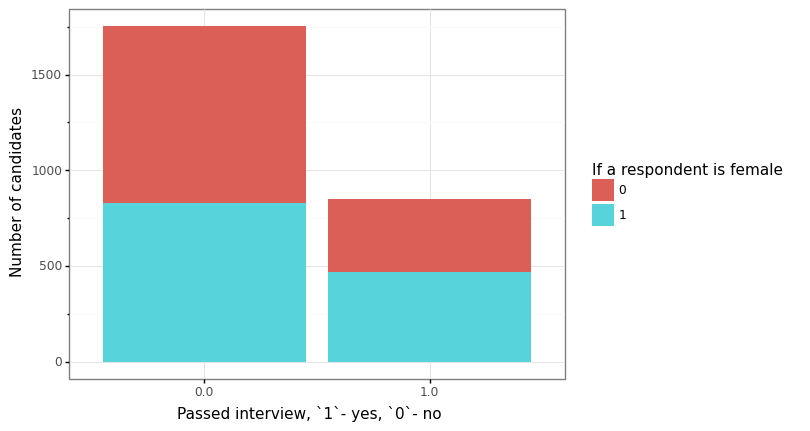

<ggplot: (-9223363264209793276)>

In [5]:
from plotnine import *

(ggplot(skills_df, aes('factor(Interview)', fill='factor(Female)')) + 
 geom_bar(position='stack') + theme_bw() + 
 labs(fill = "If a respondent is female", y = "Number of candidates", x = "Passed interview, `1`- yes, `0`- no")
 )

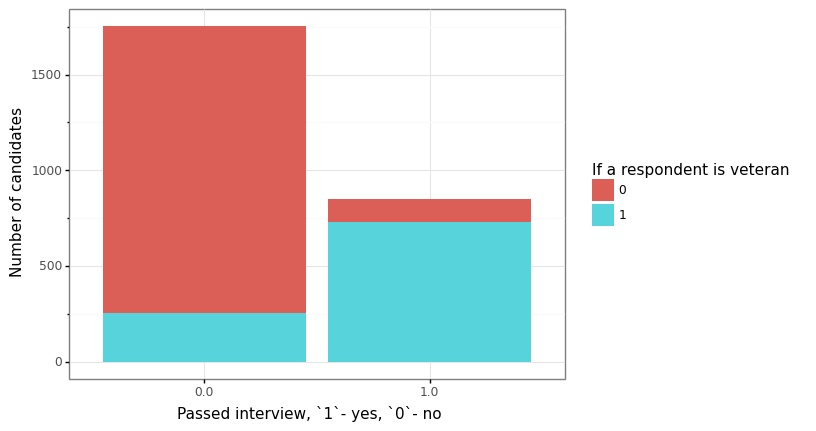

<ggplot: (8772671485679)>

In [6]:
(ggplot(skills_df, aes('factor(Interview)', fill='factor(Veteran)'))
 + geom_bar(position='stack') + theme_bw() + labs(fill = "If a respondent is veteran",
                                                 y = "Number of candidates",
                                                 x = "Passed interview, `1`- yes, `0`- no")
)

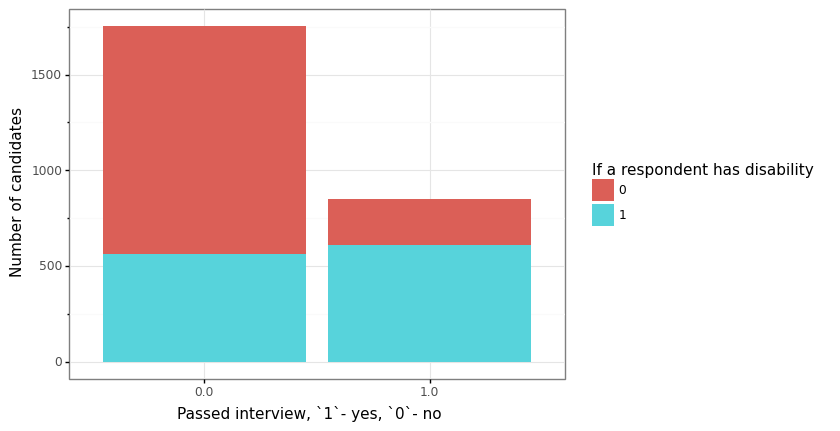

<ggplot: (-9223363264212760695)>

In [7]:
(ggplot(skills_df, aes('factor(Interview)', fill='factor(Disability)'))
 + geom_bar(position='stack') + theme_bw() + labs(fill = "If a respondent has disability",
                                                 y = "Number of candidates",
                                                 x = "Passed interview, `1`- yes, `0`- no")
)

### Clustering

In [8]:
X = skills_df[skills_df.columns[1:218]] #omitting columns 'Interview' (as a target var) 
#and 'Veteran', 'Female', 'URM', 'Disability' (as socio-demogrpaphics)
print('Array size: ', X.shape)

Array size:  (2605, 217)


In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.cluster import KMeans

def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

Optimal k is:  19


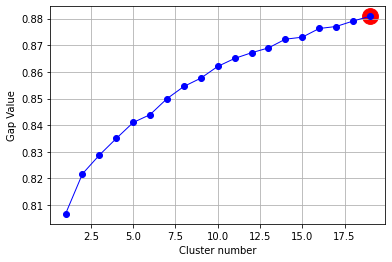

In [10]:
data=X
k, gapdf = optimalK(data, nrefs=5, maxClusters=20)
print('Optimal k is: ', k)

# строим график статистики
plt.plot(gapdf.clusterCount, gapdf.gap, '-bo', linewidth=1)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster number')
plt.ylabel('Gap Value')
plt.show()

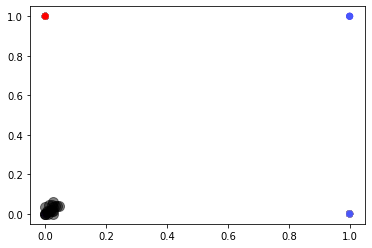

In [11]:
km19 = KMeans(n_clusters = 19, init="random", max_iter=100, n_init=1)

km19.fit(X)

X_plot = X.values
plt.scatter(X_plot[:,0],X_plot[:,1], c=km19.labels_, cmap='rainbow')
centers = km19.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

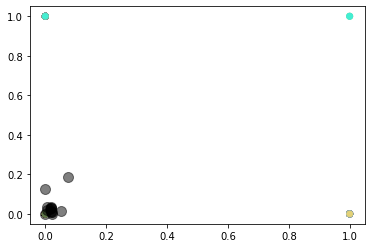

In [12]:
km14 = KMeans(n_clusters = 14, init="random", max_iter=100, n_init=1)
km14.fit(X)

plt.scatter(X_plot[:,0],X_plot[:,1], c=km14.labels_, cmap='rainbow')
centers = km14.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

In [13]:
labels = km19.labels_

X['clusters'] = labels

cols = skills_df.columns[1:218].tolist()
cols.extend(['clusters'])

clusters_stats = pd.DataFrame(X[cols].groupby(['clusters']).mean())
clusters_stats


,Adobe Illustrator,Adobe Photoshop,Agile Methodologies,Analytical Skills,Art,Art Direction,Auditing,AutoCAD,Automation,Automotive,Baseball,Basketball,Branding,Budgeting,Business Analysis,Business Intelligence,Business Planning,Business Process,Business Process Improvement,Business Services,Business Strategy,Change Management,Coaching,Communication,Company Research,Construction,Contract Negotiation,Contractual Agreements,Customer Relationship Management,Customer Satisfaction,Customer Service,Data Analysis,Databases,Decision Making,Department of Defense,Design,Development Tools,Digital Marketing,Digital Media,Diving,...,Strategic Planning,Strategy,Supervisory Skills,Swimming,Teaching,Team Building,Team Leadership,Team Management,Teamwork,Telecommunications,Testing,Time Management,Training,Troubleshooting,Underwriting,Unified Modeling Language,University Teaching,Unix,User Acceptance Testing,User Experience,User Interface Design,Validation,Vendor Management,Vendors,Video,Video Editing,Video Production,Visual Merchandising,Volleyball,Volunteer Management,Volunteering,Water Resource Management,Web Applications,Web Design,Web Development,Windows,Windows Server,Wireless Technologies,WordPress,Workshops
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.039370,0.039370,0.055118,0.015748,0.015748,0.015748,0.031496,0.023622,0.047244,0.023622,0.007874,0.007874,0.031496,0.118110,0.000000,0.023622,0.015748,0.007874,0.015748,0.031496,0.039370,0.039370,0.055118,0.039370,0.007874,0.039370,0.031496,0.031496,0.062992,0.039370,0.031496,0.102362,0.055118,0.055118,0.047244,0.015748,0.031496,0.070866,0.039370,0.118110,...,0.007874,0.007874,0.031496,0.023622,0.015748,0.023622,0.031496,0.023622,0.015748,0.007874,0.015748,0.023622,0.031496,0.007874,0.031496,0.031496,0.039370,0.007874,0.039370,0.031496,0.000000,0.039370,0.039370,0.047244,0.015748,0.031496,0.039370,0.055118,0.047244,0.031496,0.094488,0.023622,0.015748,0.023622,0.023622,0.031496,0.015748,0.047244,0.007874,0.039370
1,0.025316,0.000000,0.158228,0.044304,0.012658,0.012658,0.018987,0.000000,0.031646,0.037975,0.025316,1.000000,0.000000,0.132911,0.012658,0.031646,0.050633,0.012658,0.012658,0.012658,0.025316,0.025316,0.113924,0.025316,0.025316,0.006329,0.006329,0.018987,0.139241,0.018987,0.012658,0.088608,0.126582,0.088608,0.145570,0.025316,0.025316,0.151899,0.025316,0.164557,...,0.031646,0.018987,0.006329,0.063291,0.018987,0.044304,0.044304,0.025316,0.006329,0.037975,0.025316,0.037975,0.012658,0.018987,0.018987,0.000000,0.037975,0.018987,0.031646,0.018987,0.012658,0.037975,0.025316,0.012658,0.018987,0.018987,0.025316,0.025316,0.012658,0.025316,0.075949,0.018987,0.031646,0.012658,0.012658,0.018987,0.012658,0.018987,0.044304,0.018987
2,0.030829,0.042389,0.000000,0.026975,0.028902,0.034682,0.034682,0.050096,0.034682,0.052023,0.000000,0.000000,0.032755,0.086705,0.019268,0.026975,0.050096,0.040462,0.036609,0.042389,0.034682,0.028902,0.000000,0.021195,0.036609,0.032755,0.032755,0.032755,0.069364,0.046243,0.046243,0.094412,0.075145,0.000000,0.000000,0.036609,0.030829,0.005780,0.021195,0.086705,...,0.048170,0.032755,0.034682,0.000000,0.032755,0.042389,0.048170,0.025048,0.034682,0.034682,0.025048,0.025048,0.044316,0.030829,0.038536,0.026975,0.028902,0.032755,0.025048,0.038536,0.023121,0.028902,0.019268,0.025048,0.025048,0.052023,0.034682,0.015414,0.023121,0.021195,0.086705,0.032755,0.050096,0.036609,0.030829,0.019268,0.040462,0.038536,0.042389,0.032755
3,0.024000,0.016000,0.128000,0.040000,0.024000,0.008000,0.016000,0.024000,0.008000,0.016000,0.032000,0.048000,0.016000,0.104000,0.008000,0.040000,0.032000,0.048000,0.008000,0.024000,0.008000,0.024000,0.032000,0.008000,0.024000,0.008000,0.032000,0.048000,0.120000,0.040000,0.032000,0.112000,0.160000,0.104000,0.112000,0.040000,0.008000,0.160000,0.016000,0.128000,...,0.064000,0.032000,0.040000,0.360000,0.008000,0.008000,0.008000,0.040000,0.016000,0.024000,0.008000,0.024000,0.024000,0.032000,0.016000,0.048000,0.02400

In [14]:
clusters_stats.shape

(19, 217)

In [15]:
km19.inertia_

18992.282710944386

In [16]:
km14.inertia_

19282.68579870716

## Feature Selection

#### PCA

In [17]:
Y1 = skills_df[['Interview']].values
Y2 = skills_df[['Female']].values

X = skills_df[skills_df.columns[1:218]].values

colnames = skills_df.columns[1:218].tolist()

print(X.shape)

(2605, 217)


Size of new data (19, 217)


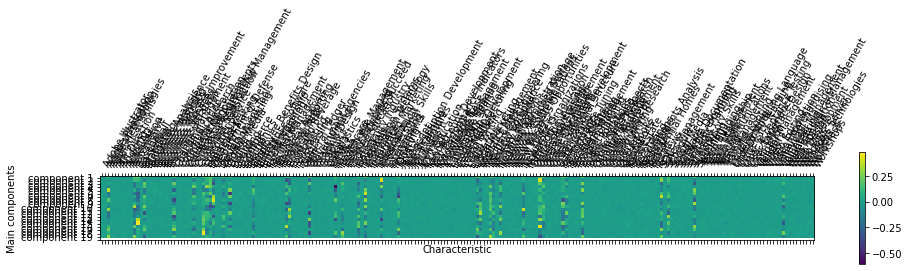

In [18]:
from sklearn.decomposition import PCA

n_components = 19 #as the number of clusters

pca = PCA(n_components)
pca.fit(X)


plt.matshow(pca.components_, cmap='viridis' )
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 
           [ "component 1" , "component 2" , "component 3", "component 4", "component 5", "component 6", "component 7", "component 8", "component 9", 
            "component 10", "component 11", "component 12", "component 13", "component 14", "component 15", "component 16", "component 17", "component 18", "component 19"])
plt.colorbar()

plt. xticks(range(len(colnames)), colnames, rotation=60, ha='left' )
plt. xlabel("Characteristic" )
plt. ylabel("Main components")


print('Size of new data', pca.components_.shape)

In [19]:
X_new = pca.transform(X)
print("оригинальный размер датасета:   ", X.shape)
print("новый размер датасета:", X_new.shape)

оригинальный размер датасета:    (2605, 217)
новый размер датасета: (2605, 19)


In [20]:
X_new

array([[ 0.71329791, -0.12208506, -0.12765375, ...,  0.9103717 ,
         0.85033001,  0.72052597],
       [ 0.73188275,  0.22288534,  0.37667813, ..., -0.33366432,
        -0.45592589, -0.15927749],
       [-0.29853918, -0.1973192 ,  0.28448605, ..., -0.15799409,
        -0.08373098, -0.101688  ],
       ...,
       [-0.22781027, -0.14605262, -0.01027733, ...,  0.01109497,
        -0.00707717,  0.0225829 ],
       [-0.13198513, -0.39208008,  0.28752505, ..., -0.18413356,
        -0.22949494,  0.70370815],
       [ 0.07217406,  0.66979997,  0.74507035, ..., -0.34854992,
        -0.12330421, -0.21283283]])

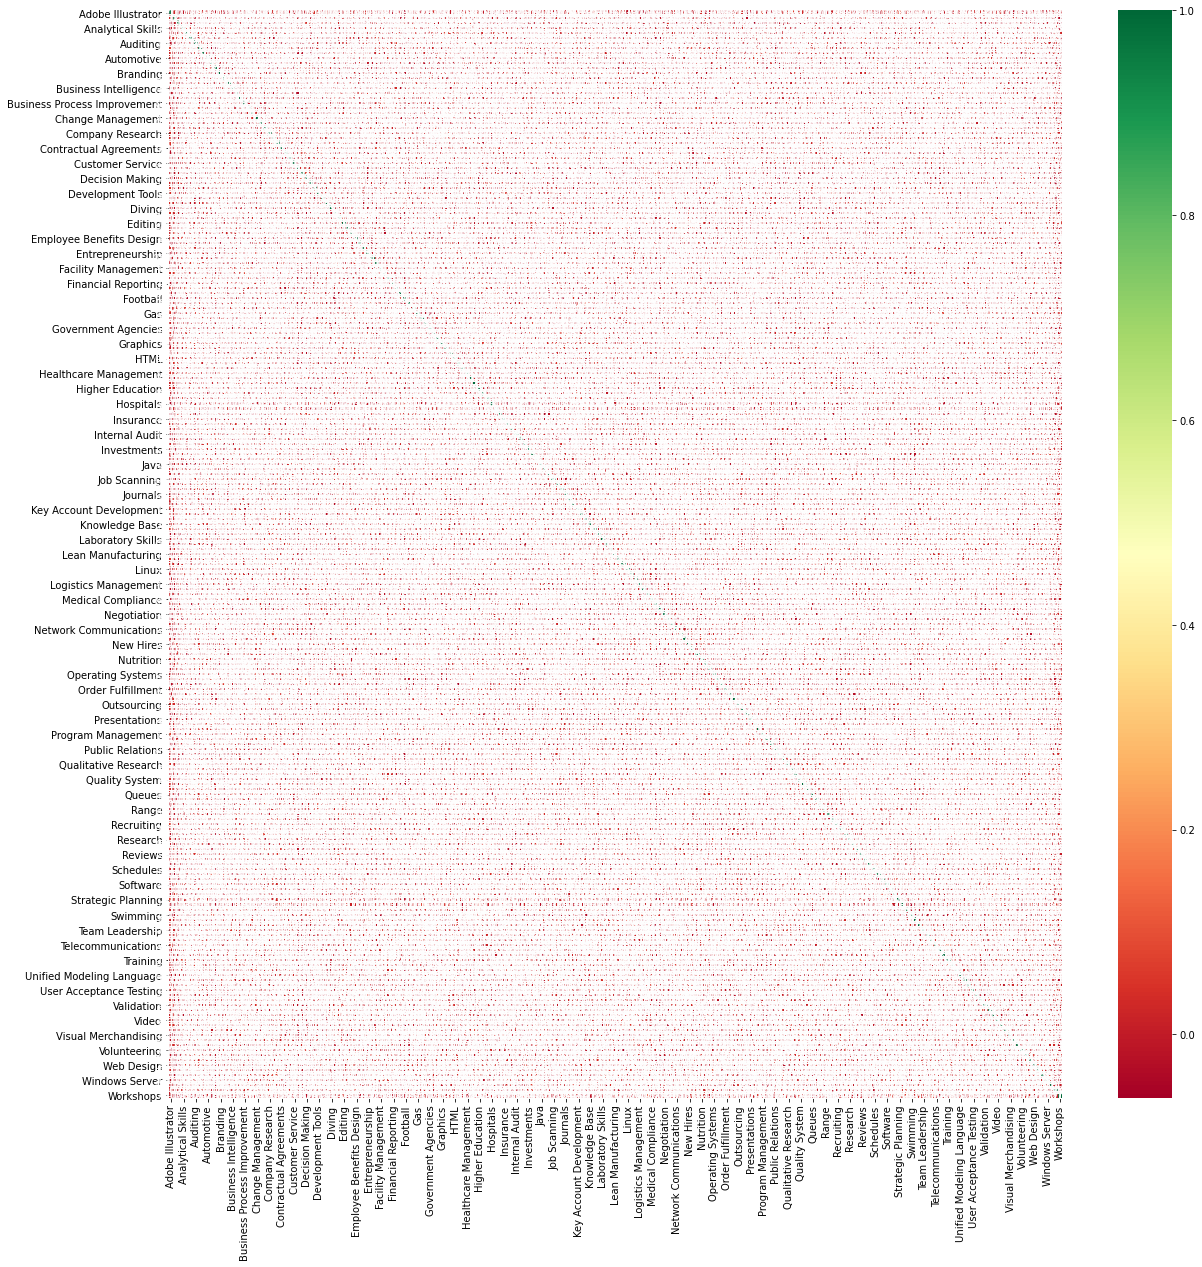

In [21]:
import seaborn as sns
skills_reddim = skills_df[skills_df.columns[1:218]]

corrmat = skills_reddim.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g = sns.heatmap(skills_reddim[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Building a classifier

In [22]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

YY1=Y1.ravel()
X_train, X_test, y1_train, y1_test = train_test_split(X_new, YY1, test_size=0.2, random_state=42)
print('Test collection size: ', X_test.shape)
print('Training collection size: ', X_train.shape)

Test collection size:  (521, 19)
Training collection size:  (2084, 19)


ADABoost: Interview

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics

seed = 750
num_trees = 500
kfold = model_selection.KFold(n_splits=10, random_state=None)
AdaBoost = AdaBoostClassifier(n_estimators=num_trees, random_state=None, learning_rate=0.01)

AdaBoost.fit(X_train, y1_train)
y1_predicted = AdaBoost.predict(X_test)

print(metrics.classification_report(y1_test, y1_predicted))
print('-------------------------------------')
print('confusion matrix')
print(metrics.confusion_matrix(y1_test, y1_predicted))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       355
         1.0       0.88      0.91      0.89       166

    accuracy                           0.93       521
   macro avg       0.92      0.93      0.92       521
weighted avg       0.93      0.93      0.93       521

-------------------------------------
confusion matrix
[[334  21]
 [ 15 151]]


Accuracy is quite high: 0.94.

Precision and recall are above 0.9 as well. The model guesses correctly more than 90% of true positives and true negatives.

In [24]:
crossvall_first = model_selection.cross_val_score(AdaBoost, X_test, y1_test, cv=kfold, scoring='f1_macro')
print(crossvall_first.mean())

0.9309695206142289


Averaged across 5 folds of cross-validation F1 score is also very high - about 0.93 

Ensemble: Interview

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

estimators = []
LR = LogisticRegression(C=0.01,
                         penalty='l2',
                         max_iter=200, 
                         tol=0.01, 
                         solver='liblinear', 
                         random_state=101)
estimators.append(('logistic', LR))

RF = RandomForestClassifier(n_estimators=500,
                             max_depth=20,
                             max_features='auto',
                             random_state=101,
                             class_weight='balanced')
estimators.append(('rf', RF))

GB = GradientBoostingClassifier(n_estimators=300, 
                                 learning_rate=0.01, 
                                 max_depth=20, 
                                 random_state=101)
estimators.append(('boost', GB))


ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y1_train)

results_first = model_selection.cross_val_score(ensemble, X_test, y1_test, cv=kfold, scoring='f1_macro')
print(results_first.mean())

0.925321070695119


Averaged across 5 folds of cross-validation F1 score is a bit higher for the ensemble model

ADABoost: Female

In [30]:
YY2=Y2.ravel()

X_train, X_test, y2_train, y2_test = train_test_split(X_new, YY2, test_size=0.2, random_state=42)
print('Test collection size: ', X_test.shape)
print('Training collection size: ', X_train.shape)

Test collection size:  (521, 19)
Training collection size:  (2084, 19)


In [31]:
AdaBoost.fit(X_train, y2_train)
y2_predicted = AdaBoost.predict(X_test)

print(metrics.classification_report(y2_test, y2_predicted))
print('-------------------------------------')
print('confusion matrix')
print(metrics.confusion_matrix(y2_test, y2_predicted))

              precision    recall  f1-score   support

         0.0       0.49      0.57      0.53       267
         1.0       0.45      0.37      0.40       254

    accuracy                           0.47       521
   macro avg       0.47      0.47      0.47       521
weighted avg       0.47      0.47      0.47       521

-------------------------------------
confusion matrix
[[153 114]
 [161  93]]


In [32]:
crossvall_second = model_selection.cross_val_score(AdaBoost, X_test, y2_test, cv=kfold, scoring='f1_macro')
print(crossvall_second.mean())

0.48761019382455606


Gender of a candidate is predicted much worse based on the same resume characteristics.

Less than 50% of true labels are predicted correctly. Averaged across 5 folds of cross-validation F1 score is also barely 0.5.

Ensemble: Female

In [33]:
ensemble.fit(X_train, y2_train)

results_second = model_selection.cross_val_score(ensemble, X_test, y2_test, cv=kfold, scoring='f1_macro')
print(results_second.mean())

0.4845137627879582


In [34]:
y2_predictedEn = ensemble.predict(X_test)

print(metrics.classification_report(y2_test, y2_predictedEn))
print('-------------------------------------')
print('confusion matrix')
print(metrics.confusion_matrix(y2_test, y2_predictedEn))

              precision    recall  f1-score   support

         0.0       0.50      0.48      0.49       267
         1.0       0.48      0.50      0.49       254

    accuracy                           0.49       521
   macro avg       0.49      0.49      0.49       521
weighted avg       0.49      0.49      0.49       521

-------------------------------------
confusion matrix
[[127 140]
 [127 127]]


About the same situation is observed for the ensemble model predicting the same target variable. However, judjing by the confusion matrix, precision is higher in this case. 